In [1]:
cd /content/drive/MyDrive/Alzheimer project/CNN_design_for_AD

/content/drive/MyDrive/Alzheimer project/CNN_design_for_AD


In [2]:
ls

AD_progression_new.png  config.yaml     datasets/  main.py           overview.png      train.ipynb
AD_progression.png      Data/           lib/       Model_eval.ipynb  README.md
all_resized.gif         data_examples/  LICENSE    models/           requirements.txt


In [3]:
!pip install -r requirements.txt


In [4]:
import argparse
import os
import sys
import shutil
import time
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
from pathlib import Path
from torch import optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import LambdaLR,MultiStepLR
from models.build_model import build_model
from torchvision import utils
import os
import datasets
import models
import math
import yaml
import numpy as np
import matplotlib.pyplot as plt

from datasets.adni_3d import ADNI_3D
from numpy.random import permutation
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp

from lib.Loss import get_loss_criterion
from lib.utils import DataParallel_withLoss, get_auc_data, accuracy, AverageMeter, balanced_accuracy_score, clip_gradients, visualize_visdom
import warnings
warnings.filterwarnings("ignore")

In [5]:


best_prec1 = 0
best_loss = 1000
best_micro_auc = 0
best_macro_auc = 0
with open('config.yaml', 'r') as f:
    cfg = yaml.safe_load(f)

percentage_usage = 1.0
expansion = 0

cfg['data']['percentage_usage'] = percentage_usage
cfg['file_name'] = cfg['file_name']+'_train_perc_'+str(percentage_usage*100)+'_expansion_'+str(expansion)+'.pth.tar'
cfg['exp_name'] = cfg['exp_name']+'_train_perc_'+str(percentage_usage*100)+'_expansion_'+str(expansion)


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [7]:

def main():
    global cfg, best_prec1, best_loss, device, best_micro_auc, best_macro_auc

    # Set seeds
    seed = 168
    torch.manual_seed(seed)
    if torch.cuda.device_count()>0:
        torch.cuda.manual_seed(seed)

    main_model = build_model(cfg)
    main_model = main_model.to(device)


    criterion = get_loss_criterion(cfg,type='CrossEntropyLoss').to(device)

    #Loss parallel
    model = DataParallel_withLoss(main_model,criterion)

    if hasattr(model, 'module'):
        print('has module!')
        model = model.module

    # Optimization set up
    params = [{'params': filter(lambda p: p.requires_grad, model.parameters())}]


    main_optim = getattr(optim, cfg['optimizer']['method'])(
        params, **cfg['optimizer']['par'])

    scheduler = MultiStepLR(main_optim, milestones=[20,50], gamma=0.1)#get_optim_scheduler(main_optim)
    # Plot with visdom
    if cfg['visdom']['server'] is not None:
        viz_plot = visualize_visdom(cfg)
    #Load data
    dir_to_scans = cfg['data']['dir_to_scans']
    dir_to_tsv = cfg['data']['dir_to_tsv']
    train_dataset = ADNI_3D(dir_to_scans, dir_to_tsv, mode = 'Train',
        n_label = cfg['model']['n_label'], percentage_usage=cfg['data']['percentage_usage'])
    val_dataset = ADNI_3D(dir_to_scans, dir_to_tsv, mode = 'Val', n_label = cfg['model']['n_label'])


    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=cfg['data']['batch_size'], shuffle=True,
        num_workers=cfg['data']['workers'], pin_memory=True, drop_last=True)

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=cfg['data']['val_batch_size'], shuffle=False,
        num_workers=cfg['data']['workers'], pin_memory=True)

    ndata = len(train_dataset.subject_id)
    print('In total ', str(ndata), ' patients in training set')

    # Training !!!
    for epoch in range(cfg['training_parameters']['start_epoch'], cfg['training_parameters']['epochs']):

        # train for one epoch
        train_loss, train_acc = train(cfg,train_loader, model, scheduler, criterion, main_optim, epoch)



        # evaluate on validation set
        val_loss, val_acc, confusion_matrix, auc_outs = validate(cfg,val_loader,model,criterion,epoch)
        #prec1 /= len(val_dataset)
        #scheduler.step()
        print('Epoch [{0}]: Validation Accuracy {prec1:.3f}\t'.format(
               epoch, prec1=val_acc))

        if cfg['visdom']['server'] is not None:
            viz_plot.plot(epoch, train_loss, val_loss, train_acc, val_acc, confusion_matrix, auc_outs)



        # Save model
        is_best = (val_acc > best_prec1)
        lowest_loss = (val_loss < best_loss)
        is_best_micro_auc = (auc_outs[2][len(auc_outs[2])-2]>= best_micro_auc)
        is_best_macro_auc = (auc_outs[2][len(auc_outs[2])-1]> best_macro_auc)

        best_prec1 = max(val_acc, best_prec1)
        best_loss = min(val_loss,best_loss)

        best_micro_auc = max(auc_outs[2][len(auc_outs[2])-2], best_micro_auc)
        best_macro_auc = max(auc_outs[2][len(auc_outs[2])-1], best_macro_auc)

        is_best_auc = (auc_outs[2][len(auc_outs[2])-2]>0.8) & (auc_outs[2][len(auc_outs[2])-1]>0.8)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'best_loss' : best_loss,
            'optimizer' : main_optim.state_dict(),
        }, is_best, lowest_loss, is_best_micro_auc, is_best_macro_auc, is_best_auc, filename=cfg['file_name'])


def train(cfg, train_loader, main_model, scheduler,
    criterion,  main_optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    main_losses = AverageMeter()

    # switch to train mode
    main_model.train()

    end = time.time()

    logit_all = []
    target_all = []
    for i, (input, target, index, mmse, segment,age) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)


        index = index.to(device)
        if cfg['training_parameters']['use_age']:
            age = age.to(device)
        else:
            age = None

        # compute output
        input = input.to(device)
        target = target.to(device)

        main_loss, logit = main_model([input, age], target)
        main_loss = main_loss.mean()

        logit_all.append(logit.data.cpu())
        target_all.append(target.data.cpu())
        acc,_ = accuracy(logit.data.cpu(),target.data.cpu())

        main_optimizer.zero_grad()
        main_loss.backward()
        clip_gradients(main_model, i, cfg['training_parameters']['max_grad_l2_norm'])
        main_optimizer.step()

        # measure accuracy and record loss
        main_losses.update(main_loss.cpu().item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % cfg['training_parameters']['print_freq'] == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Accuracy {accuracy:.3f}\t'.format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=main_losses, accuracy=acc[0].item()))

    logit_all = torch.cat(logit_all).numpy()
    target_all = torch.cat(target_all).numpy()
    acc_all = balanced_accuracy_score(target_all, np.argmax(logit_all,1))


    return main_losses.avg, acc_all*100

def validate(cfg,val_loader,main_model,criterion,epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    main_losses = AverageMeter()

    end = time.time()
    correct_all = 0.0

    # switch to validation mode
    main_model.eval()

    confusion_matrix = torch.zeros(cfg['model']['n_label'], cfg['model']['n_label'])
    logit_all = []
    target_all = []

    for i, (input, target, patient_idx, mmse, segment,age) in enumerate(val_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        input = input.to(device)
        target = target.to(device)
        if cfg['training_parameters']['use_age']:
            age = age.to(device)
        else:
            age = None
        # compute output

        main_loss, logit = main_model([input, age], target)
        main_loss = main_loss.mean()

        logit_all.append(torch.tensor(logit.data.cpu()))
        target_all.append(torch.tensor(target.data.cpu()))
        acc,_ = accuracy(logit.data.cpu(),target.data.cpu())
        _, preds = torch.max(logit.cpu(), 1)
        for t, p in zip(target.cpu().view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

        acc,correct = accuracy(logit.cpu(),target.cpu())
        correct_all += correct[0].item()

        # measure accuracy and record loss
        main_losses.update(main_loss.cpu().item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()


        if i % cfg['training_parameters']['print_freq'] == 0:
            print('Validation [{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Accuracy {accuracy:.3f}\t'.format(
                   epoch, i, len(val_loader), batch_time=batch_time,
                   data_time=data_time, loss=main_losses, accuracy=acc[0].item()))

    #plot AUC curves
    logit_all = torch.cat(logit_all).numpy()
    target_all = torch.cat(target_all).numpy()
    acc_all = balanced_accuracy_score(target_all, np.argmax(logit_all,1))
    plotting_fpr, plotting_tpr, roc_auc = get_auc_data(logit_all, target_all,cfg['model']['n_label'])


    return main_losses.avg, acc_all*100, confusion_matrix, [plotting_fpr, plotting_tpr, roc_auc]


def save_checkpoint(state, is_best, lowest_loss, is_best_micro_auc, is_best_macro_auc, is_best_auc, filename='checkpoint.pth.tar'):
    saving_dir = Path(filename).parent
    print(saving_dir)
    if not os.path.exists(saving_dir):
        os.mkdir(saving_dir)
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, filename.replace('.pth.tar','')+'_model_best.pth.tar')
    if lowest_loss:
        shutil.copyfile(filename, filename.replace('.pth.tar','')+'_model_low_loss.pth.tar')
    if is_best_micro_auc:
        shutil.copyfile(filename, filename.replace('.pth.tar','')+'_model_best_micro.pth.tar')
    if is_best_macro_auc:
        shutil.copyfile(filename, filename.replace('.pth.tar','')+'_model_best_macro.pth.tar')
    if is_best_auc:
        shutil.copyfile(filename, filename.replace('.pth.tar','')+'_model_best_auc.pth.tar')




if __name__ == '__main__':
    main()

has module!
In total  21  patients in training set
Epoch: [0][0/5]	Time 4.201 (4.201)	Data 2.197 (2.197)	Loss 1.0925 (1.0925)	Accuracy 75.000	
Validation [0/3]	Time 3.990 (3.990)	Data 3.660 (3.660)	Loss 0.9298 (0.9298)	Accuracy 50.000	
Epoch [0]: Validation Accuracy 33.333	
saved_model
Epoch: [1][0/5]	Time 3.770 (3.770)	Data 2.660 (2.660)	Loss 1.1916 (1.1916)	Accuracy 0.000	
Validation [0/3]	Time 1.621 (1.621)	Data 1.382 (1.382)	Loss 0.9963 (0.9963)	Accuracy 50.000	
Epoch [1]: Validation Accuracy 33.333	
saved_model
Epoch: [2][0/5]	Time 3.138 (3.138)	Data 2.067 (2.067)	Loss 1.1463 (1.1463)	Accuracy 25.000	
Validation [0/3]	Time 1.826 (1.826)	Data 1.590 (1.590)	Loss 0.9487 (0.9487)	Accuracy 50.000	
Epoch [2]: Validation Accuracy 33.333	
saved_model
Epoch: [3][0/5]	Time 2.944 (2.944)	Data 1.876 (1.876)	Loss 1.1348 (1.1348)	Accuracy 50.000	
Validation [0/3]	Time 1.180 (1.180)	Data 0.951 (0.951)	Loss 0.9400 (0.9400)	Accuracy 50.000	
Epoch [3]: Validation Accuracy 33.333	
saved_model
Epoch:

In [8]:
dir_to_scans = '/content/drive/MyDrive/ADNI_processed_v2/subjects'
dir_to_tsv = '/content/drive/MyDrive/sample_30'
Test_dataset = ADNI_3D(dir_to_scans, dir_to_tsv, mode = 'Test',  n_label = cfg['model']['n_label'])
Test_loader = torch.utils.data.DataLoader(
        Test_dataset, batch_size=cfg['data']['val_batch_size'], shuffle=False,
        num_workers=cfg['data']['workers'], pin_memory=True)

In [9]:
category = ['CN','MCI','AD']


In [10]:
def visualize_example(Test_dataset,sub_id):
    plt.figure(figsize=(10, 10))
    image = Test_dataset.__getitem__(sub_id)[0][0]
    plt.subplot(1, 3, 1)
    plt.imshow(np.rot90(image[26,:,:]),cmap = 'gray')
    plt.ylabel('Subject '+str(sub_id) + ' in Test dataset', fontsize=10)
    plt.title('Class: '+category[Test_dataset.__getitem__(sub_id)[1]] , fontsize=10)
    plt.subplot(1, 3, 2)
    plt.imshow(np.rot90(image[:,57,:]),cmap = 'gray')
    plt.title('Class: '+category[Test_dataset.__getitem__(sub_id)[1]], fontsize=10)
    plt.subplot(1, 3, 3)
    plt.imshow(np.rot90(image[:,:,50]),cmap = 'gray')
    plt.title('Class: '+category[Test_dataset.__getitem__(sub_id)[1]], fontsize=10)

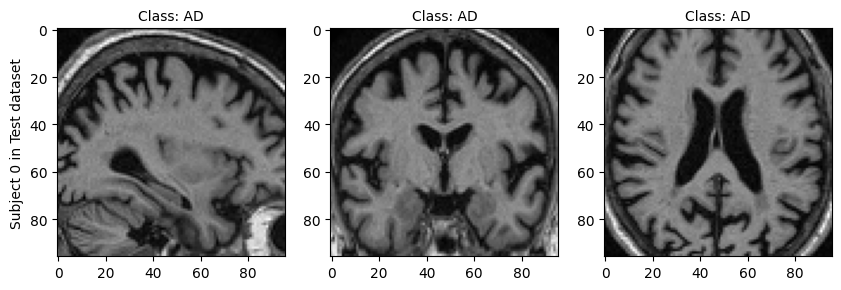

In [11]:
visualize_example(Test_dataset,0)


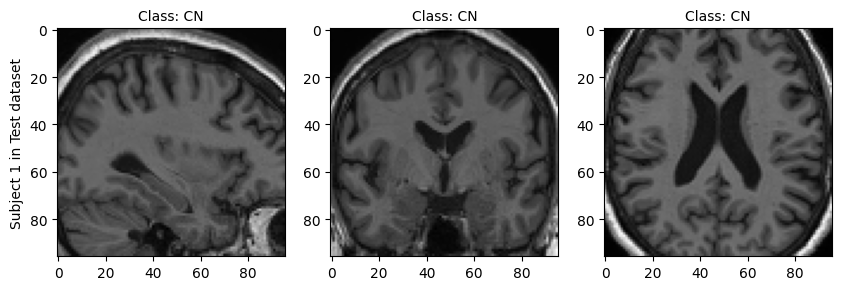

In [12]:
visualize_example(Test_dataset,1)


In [13]:
from sklearn.metrics import confusion_matrix
def balanced_accuracy_score(y_true, y_pred, sample_weight=None,
                            adjusted=False):
    C = confusion_matrix(y_true, y_pred, sample_weight=sample_weight)
    with np.errstate(divide='ignore', invalid='ignore'):
        per_class = np.diag(C) / C.sum(axis=1)
    if np.any(np.isnan(per_class)):
        warnings.warn('y_pred contains classes not in y_true')
        per_class = per_class[~np.isnan(per_class)]
    score = np.mean(per_class)
    if adjusted:
        n_classes = len(per_class)
        chance = 1 / n_classes
        score -= chance
        score /= 1 - chance
    return score

In [14]:
def calc_aucs(target_all,logit_all):
    y = label_binarize(target_all, classes=[0,1,2])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for k in range(cfg['model']['n_label']):
        fpr[k], tpr[k], _ = roc_curve(y[:, k], logit_all[:, k])
        roc_auc[k] = auc(fpr[k], tpr[k])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), logit_all.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[k] for k in range(cfg['model']['n_label'])]))

    mean_tpr = np.zeros_like(all_fpr)
    for k in range(cfg['model']['n_label']):
        mean_tpr += interp(all_fpr, fpr[k], tpr[k])

    # Finally average it and compute AUC
    mean_tpr /= cfg['model']['n_label']

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    return roc_auc

In [15]:
def plot_rocs(target_all,logit_all):
    y = label_binarize(target_all, classes=[0,1,2])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for k in range(cfg['model']['n_label']):
        fpr[k], tpr[k], _ = roc_curve(y[:, k], logit_all[:, k])
        roc_auc[k] = auc(fpr[k], tpr[k])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), logit_all.ravel())
    roc_auc[k+1] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[k] for k in range(cfg['model']['n_label'])]))

    mean_tpr = np.zeros_like(all_fpr)
    for k in range(cfg['model']['n_label']):
        mean_tpr += interp(all_fpr, fpr[k], tpr[k])

    # Finally average it and compute AUC
    mean_tpr /= cfg['model']['n_label']

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc[k+2] = auc(fpr["macro"], tpr["macro"])
    plotting_fpr = []
    plotting_tpr = []
    for k in range(cfg['model']['n_label']):
        plotting_fpr.append(fpr[k])
        plotting_tpr.append(tpr[k])
    plotting_fpr += [fpr["micro"], fpr["macro"]]
    plotting_tpr += [tpr["micro"], tpr["macro"]]
    auc_outs = [plotting_fpr, plotting_tpr, roc_auc]
    name = ['CN vs all ','MCI vs all ', 'AD vs all ', 'Micro ', 'Macro ']
    from itertools import cycle
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','navy','deeppink'])
    plt.figure()
    for i, color in zip(range(len(auc_outs[0])), colors):
        plt.plot(auc_outs[0][i], auc_outs[1][i], color=color, lw=2, label=name[i] + 'ROC curve (area = %0.2f)' % auc_outs[2][i])
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC curves')
    plt.legend(loc="lower right")

In [16]:
def run_epoch(model,val_loader,use_age=False):
    logit_all = []
    target_all = []
    mmse_all = []
    patient_idx_all = []
    cdr_all = []
    for i, (input, target, patient_idx, mmse, cdr_sub, age_id) in enumerate(val_loader):
        if i % 20 == 0:
            print('Iteration: ',i)
        input = input.to(device)
        target = target.to(device)
        if use_age:
            age_id = age_id.to(device)
        else:
            age_id = None
        logit = model(input,age_id)
        logit_all.append(logit.data.cpu())
        target_all.append(target.data.cpu())
        mmse_all.append(mmse.cpu())
        patient_idx_all.append(patient_idx.cpu())
        cdr_all.append(cdr_sub.cpu())

    logit_all_catted = torch.cat(logit_all)
    target_all_catted = torch.cat(target_all)
    mmse_all_catted = torch.cat(mmse_all)
    patient_idx_all_catted = torch.cat(patient_idx_all)
    cdr_all_catted = torch.cat(cdr_all)
    return logit_all_catted.numpy(), target_all_catted.numpy(), mmse_all_catted.numpy(), patient_idx_all_catted.numpy(), cdr_all_catted.numpy()

In [17]:
def evaluation_models(model_name,data_loader, expansion_list = [1],  num_trails = 10,percentage = 0.8, use_age = False, norm_type= 'Instance'):

    all_acc = np.zeros((len(expansion_list),num_trails))
    all_balanced_acc = np.zeros((len(expansion_list),num_trails))
    all_auc = []
    for i,ep in enumerate(expansion_list):
        cfg['model']['expansion'] = ep
        cfg['model']['norm_type'] = norm_type
        model = build_model(cfg)
        best_model_dir = './saved_model/'
        pretrained_dict = torch.load(best_model_dir+model_name + '_model_low_loss.pth.tar',map_location='cuda',weights_only= False)['state_dict']
        old_ks = list(pretrained_dict.keys()).copy()
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:]in model_dict.keys())}
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
        model = model.to(device)
        model = model.eval()
        logit_all,target_all,_,_,_= run_epoch(model, data_loader, use_age)
        #print(F.softmax(torch.tensor(logit_all[0:20]),dim=1))
        tes_auc = []
        for tes in range(num_trails):
            rand_idex = permutation(range(len(target_all)))[:int(percentage*len(target_all))]
            target_test = target_all[rand_idex]
            pred_test = np.argmax(logit_all,1)[rand_idex]
            logit_test = logit_all[rand_idex]
            all_acc[i,tes] =accuracy_score(target_test, pred_test)
            all_balanced_acc[i,tes] =balanced_accuracy_score(target_test, pred_test)
            tes_auc.append(calc_aucs(target_test,logit_test))
        plot_rocs(target_test,logit_test)
        all_auc.append(tes_auc)
        print(old_ks)
        print(list(pretrained_dict.keys()))
    return all_acc, all_balanced_acc, all_auc

In [18]:
def test_model(all_acc, all_balanced_acc,all_auc):
    for w_k in range(len(all_acc)):
        print('Mean Acc ', np.mean(all_acc[w_k]),'\t')
        print('STD Acc ', np.std(all_acc[w_k]),'\t')
        print('Mean Balanced Acc ', np.mean(all_balanced_acc[w_k]),'\t')
        print('std Balanced Acc ', np.std(all_balanced_acc[w_k]),'\t')
        avg_micro = []
        avg_macro = []
        for d in all_auc[w_k]:
            avg_micro.append( d['micro'])
            avg_macro.append( d['macro'])
        print('Micro mean: ',np.mean(avg_micro))
        print('Micro std: ', np.std(avg_micro))
        print('Macro mean: ',np.mean(avg_macro))
        print('Macro std: ',np.std(avg_macro))

In [21]:
model = build_model(cfg)
model_file_name = 'exp1_train_perc_100.0_expansion_0'

Iteration:  0
['model.image_embedding_model.conv.conv0_s1.weight', 'model.image_embedding_model.conv.conv0_s1.bias', 'model.image_embedding_model.conv.conv1_s1.weight', 'model.image_embedding_model.conv.conv1_s1.bias', 'model.image_embedding_model.conv.conv2_s1.weight', 'model.image_embedding_model.conv.conv2_s1.bias', 'model.image_embedding_model.conv.conv3_s1.weight', 'model.image_embedding_model.conv.conv3_s1.bias', 'model.image_embedding_model.fc6.fc6_s1.weight', 'model.image_embedding_model.fc6.fc6_s1.bias', 'model.image_embedding_model.age_encoder.pe', 'model.image_embedding_model.age_encoder.fc6.fc6_s1.weight', 'model.image_embedding_model.age_encoder.fc6.fc6_s1.bias', 'model.image_embedding_model.age_encoder.fc6.lrn0_s1.weight', 'model.image_embedding_model.age_encoder.fc6.lrn0_s1.bias', 'model.image_embedding_model.age_encoder.fc6.fc6_s3.weight', 'model.image_embedding_model.age_encoder.fc6.fc6_s3.bias', 'model.classifier.classifier.LinearClassifier.weight', 'model.classifier.

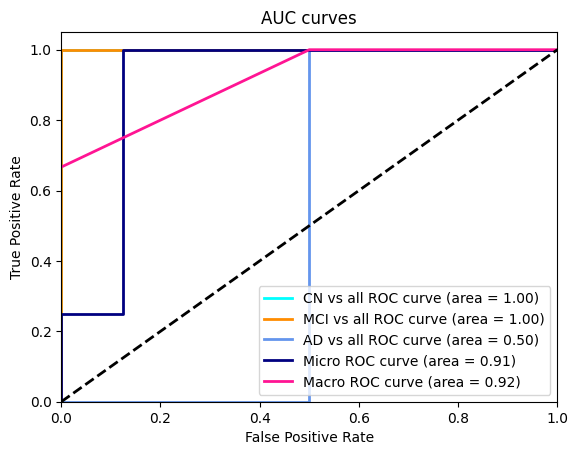

In [22]:
all_acc, all_balanced_acc, all_auc = evaluation_models(model_file_name,Test_loader, expansion_list = [8], use_age = True, norm_type= 'Instance')


In [23]:
test_model(all_acc, all_balanced_acc,all_auc)


Mean Acc  0.775 	
STD Acc  0.075 	
Mean Balanced Acc  0.7 	
std Balanced Acc  0.1 	
Micro mean:  0.934375
Micro std:  0.025958199571618986
Macro mean:  nan
Macro std:  nan
